In [10]:
import h5py
import numpy as np
import pandas as pd
import torch
import os
import glob
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns

classes = {
    0: 'Large Nuclei',
    1: 'CTCs',
    2: 'imCTCs',
    3: 'pcCTCs',
    4: 'Megakaryocyte-Like Cells',
    5: 'CECs',
    6: 'Fibroblast-Like Cells',
    7: 'Lymphoid Cells',
    8: 'Granulocytes',
    9: 'Monocytes/Macrophages'
}

colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'red', 'purple',
		  'brown', 'pink', 'gray', 'olive', 'lightgray', 'yellow']

colors_dict = {k: c for k, c in zip(classes.values(), colors)}
fe = fm.FontEntry(
	fname='/mnt/deepstore/LBxPheno/figures/Helvetica.ttf',
	name='helvetica')
fm.fontManager.ttflist.insert(0, fe)
mpl.rcParams['font.family'] = fe.name
plt.rcParams.update({'font.size': 11, 'font.family': 'helvetica'})

In [11]:
import os
import sys

# Add the project root to the Python path
# Get the notebook's directory and go up to project root
notebook_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_dir, "../.."))
sys.path.append(project_root)

from src.representation_learning.data_loader import CustomImageDataset
from src.representation_learning.model_cl import CL
from src.utils import utils



np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = 'cuda:0'

#model
#model_path = '/mnt/deepstore/LBxPheno/pipeline/model_weights/representation_model.pth'
model_path = '/mnt/deepstore/LBxPheno/pipeline/model_weights/representation_learning_04_28.pth'
model = CL(in_channels=5, h_dim=128, projection_dim=64)
state_dict = torch.load(model_path)['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
model.to(device)

CL(
  (encoder): Encoder(
    (conv1): Conv2d(5, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (adap_pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=256, out_features=128, bias=True)
  )
  (projector): Sequential(
    (0): Linear(in_features=128, out_features=128, bia

In [12]:
def get_data_loaders(data_path, batch_size=64):
    types = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    images_list = []
    masks_list = []
    labels_list = []
    print(types)
    for label, t in enumerate(types):
        print(t)
        current_type_path = os.path.join(data_path, t)
        current_type_files = glob.glob(os.path.join(current_type_path, "*.hdf5"))
        class_images = []
        class_masks = []


        for file_path in current_type_files:
            with h5py.File(file_path, 'r') as f:
                imgs = np.array(f['images'][:])  # Ensure dtype matches the image data type
                msks = np.array(f['masks'][:])

                class_images.append(imgs)
                class_masks.append(msks)
                
        class_images = np.concatenate(class_images, axis=0)
        class_masks = np.concatenate(class_masks,axis=0)


        # (n, 75, 75, 1) for masks. if (n, 75, 75) then expand dims
        if len(class_masks.shape) == 3:
            class_masks = np.expand_dims(class_masks, axis=-1)
        
        #if mask > 0, then 1
        class_masks[class_masks > 0] = 1

        
        images_list.append(class_images)
        masks_list.append(class_masks)
        labels_list.append(np.full(len(class_images), label, dtype=np.int64))

    # Concatenate lists to form arrays
    
    images = np.concatenate(images_list, axis=0)
    masks = np.concatenate(masks_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    print(images.shape, masks.shape, labels.shape)

    return images, masks, labels

In [13]:
#data_path
dp = '/mnt/deepstore/LBxPheno/figures/figure2/data_dropped_NAN_CECs'
rare_images, rare_masks, rare_labels = get_data_loaders(dp, batch_size=512)

['Large_Nuclear', 'CTCs', 'IM_CTC', 'PC_CTCs', 'Megakaryocytes', 'CECs', 'Large_Vimentin']
Large_Nuclear
CTCs
IM_CTC
PC_CTCs
Megakaryocytes
CECs
Large_Vimentin
(2166, 75, 75, 4) (2166, 75, 75, 1) (2166,)


In [14]:
with h5py.File('/mnt/deepstore/LBxPheno/figures/figure3/data/0ADD705_gated_full_final.hdf5', 'r') as f:
   raw_wbcimages = f['padded_images'][:]
   raw_wbcmasks = f['masks'][:]
raw_features = pd.read_hdf('/mnt/deepstore/LBxPheno/figures/figure3/data/0ADD705_gated_full_final.hdf5', 'features')

# sample n_sample of each group in features
raw_features['Multiclass_3'] = raw_features['Multiclass_5'].map({
	'Granulocytes': 'Granulocytes',
	'T-cells': 'Lymphocytes',
	'Monocyte/Macrophages': 'Monocyte/Macrophages',
	'B-cells': 'Lymphocytes',
	'NK-cells': 'Lymphocytes'
})

# sample n_sample of each group in Multiclass_3
# indices = features.groupby('Multiclass_3').apply(lambda x: x.sample(n_sample, random_state=42).index).reset_index(drop=True)
# indices = indices.apply(lambda x: x.tolist())
# all_indices = []
# for batch in indices:
# 	print(len(batch))
# 	all_indices.extend(batch)



# Find the indices of the images that have a mask that is entirely 0 pixels
indices = []
for i in range(len(raw_wbcmasks)):
    if np.sum(raw_wbcmasks[i]) == 0:
        indices.append(i)

#delete the images and masks that have a mask that is entirely 0 pixels
raw_wbcimages = np.delete(raw_wbcimages, indices, axis=0)
raw_wbcimages = np.delete(raw_wbcimages, indices, axis=0)

#delete the corresponding rows in the features
raw_features = raw_features.drop(raw_features.index[indices])

#set all non-zero pixels in the mask to 1
raw_wbcmasks[raw_wbcmasks > 0] = 1

wbclabels = raw_features['Multiclass_5'].values
wbclabels[wbclabels == 'Granulocytes'] = 7
wbclabels[wbclabels == 'T-cells'] = 8
wbclabels[wbclabels == 'Monocyte/Macrophages'] = 9
wbclabels[wbclabels == 'B-cells'] = 8#10
wbclabels[wbclabels == 'NK-cells'] = 8#11

In [15]:
#print shape of raw_wbcimages

print(raw_wbcimages.shape, raw_wbcmasks.shape, raw_features.shape)

(30059, 75, 75, 4) (30059, 75, 75, 1) (30059, 94)


In [16]:
# ----------------------------- imports ----------------------------------
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.preprocessing   import StandardScaler
from sklearn.decomposition   import PCA
from sklearn.cluster         import KMeans
from sklearn.neighbors       import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics         import (
    adjusted_rand_score, normalized_mutual_info_score,
    adjusted_mutual_info_score, homogeneity_score, completeness_score,
)

import igraph as ig
import leidenalg
import torch


In [17]:
results = []                                      # <-- list of rows
score_names = ['ARI', 'NMI', 'AMI', 'Homogeneity', 'Completeness']

def collect_results(ratio, features, clustering, score_names, score_values):
    row = dict(ratio=ratio, features=features, clustering=clustering)
    row.update(dict(zip(score_names, score_values)))
    results.append(row)                           # works, results is a list

In [18]:
LABEL_MAP = {
    "Granulocytes": 7,
    "T-cells": 8,
    "Monocyte/Macrophages": 9,
    "B-cells": 8,    # 10 collapsed into 8
    "NK-cells": 8,   # 11 collapsed into 8
}

# clustering / HDBSCAN hyper‑params (tweak as needed)
k                = 15          # K‑NN for Leiden
min_size_cluster = 50
min_samples      = 15

# where the two CellProfiler feature tables live
TRAD_PATHS = [
    "/mnt/deepstore/LBxPheno/dev/robustness_test/blurred_sigma_0.0_trad_feat.txt",
    "/mnt/deepstore/LBxPheno/figures/figure3/tifs/features.txt",
]

# ratios we want to test
RATIOS = [0.5, 1, 2, 4, 7, 10]


In [19]:
# ────────────────────────── EXTRA IMPORTS ────────────────────────────────
import umap
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# colour palette for up to 10 classes (repeat or change as needed)
PALETTE = sns.color_palette("tab10", 10)

def scatter_umap(ax, coords, labels, title):
    """Convenience plotter: scatter UMAP coords coloured by integer labels."""
    ax.scatter(
        coords[:, 0], coords[:, 1],
        c=[PALETTE[l % len(PALETTE)] for l in labels],
        s=8, alpha=0.8, linewidths=0
    )
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title, fontsize=10)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
def add_umap_page(pdf, coords, true_labels, pred_labels,
                  ratio, feat_name, algo_name):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=300)
    scatter_umap(axes[0], coords, true_labels,  "True labels")
    scatter_umap(axes[1], coords, pred_labels,  f"{algo_name} clusters")
    fig.suptitle(f"Ratio {ratio} — {feat_name} — {algo_name}", fontsize=12)
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)


In [21]:
def clustering_metrics(y_true, y_pred):
    return dict(
        ARI=adjusted_rand_score(y_true, y_pred),
        NMI=normalized_mutual_info_score(y_true, y_pred),
        AMI=adjusted_mutual_info_score(y_true, y_pred),
        Homogeneity=homogeneity_score(y_true, y_pred),
        Completeness=completeness_score(y_true, y_pred),
    )


In [22]:
def sample_wbcs(raw_feats, raw_imgs, raw_masks, n_cells, seed=42):
    idx     = raw_feats.sample(n_cells, random_state=seed).index.tolist()
    feats   = raw_feats.loc[idx].copy()
    imgs    = raw_imgs[idx]
    masks   = raw_masks[idx]

    keep    = [i for i, m in enumerate(masks) if m.sum() > 0]
    imgs    = imgs [keep]
    masks   = masks[keep]
    feats   = feats.iloc[keep]

    masks[masks > 0] = 1           # binarise
    labels  = feats["Multiclass_5"].replace(LABEL_MAP).astype(int).values
    return imgs, masks, labels, idx


In [23]:
def load_traditional_wbcfeatures(path, img_idx=None):
    df = pd.read_csv(path, sep="\t")
    df["img_index"] = (
        df["image_name"].str.split("_").str[1].str.split(".").str[0].astype(int)
    )
    df = df.sort_values("img_index").reset_index(drop=True)
    if img_idx is not None:
        df = df.loc[img_idx].reset_index(drop=True)

    drop_starts = ("nucleusf.", "cellf.B")
    drop_ends   = (".cx", ".cy")
    drop_cont   = ("theta", "nucleus_cell_dist", "cell_nucleus_ratio", "tritc_cy5_ratio")

    keep = [
        c for c in df.columns
        if not c.startswith(drop_starts)
        and not c.endswith(drop_ends)
        and not any(x in c for x in drop_cont)
    ]
    
    return df[keep].drop(columns=["img_index", "image_name"])


In [24]:
def load_raretrad_features(path):
    df = pd.read_csv(path, sep="\t")
   
    drop_starts = ("nucleusf.", "cellf.B", "frame_id","cell_id","x","y","slide_id")
    drop_ends   = (".cx", ".cy")
    drop_cont   = ("theta", "nucleus_cell_dist", "cell_nucleus_ratio", "tritc_cy5_ratio")
    

    keep = [
        c for c in df.columns
        if not c.startswith(drop_starts)
        and not c.endswith(drop_ends)
        and not any(x in c for x in drop_cont)
    ]
    
    return df[keep].drop(columns=["image_name"])

In [25]:
def pca_features(df, n_components=128):
    X      = StandardScaler().fit_transform(df)
    pca    = PCA(n_components=n_components).fit(X)
    return pca.transform(X), pca.explained_variance_ratio_.sum()


In [26]:
def get_embeddings_array(imgs, masks, labels):
    ds = CustomImageDataset(imgs, masks, labels)
    dl = torch.utils.data.DataLoader(ds, batch_size=512, shuffle=False)
    emb = utils.get_embeddings(model, dl, device).cpu().numpy()
    return StandardScaler().fit_transform(emb)



In [27]:
def kmeans_results(X, y, n_clusters=10):
    km   = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    lab  = km.labels_
    mets = clustering_metrics(y, lab)
    return mets, lab

def leiden_results(X, y, neighbors):
    nbr  = NearestNeighbors(n_neighbors=neighbors, metric="cosine").fit(X)
    dist, idx = nbr.kneighbors(X)
    sims = 1 - dist
    n    = X.shape[0]
    rows = np.repeat(np.arange(n), neighbors)
    A    = sp.coo_matrix((sims.ravel(), (rows, idx.ravel())), shape=(n, n))
    A    = A.maximum(A.T)
    g    = ig.Graph.Adjacency((A > 0).toarray().tolist()).as_undirected()
    g.es["weight"] = A.data
    lab  = leidenalg.find_partition(
        g, leidenalg.ModularityVertexPartition, weights="weight"
    ).membership
    mets = clustering_metrics(y, lab)
    return mets, np.array(lab)


In [28]:
def run_one_ratio(ratio, raw_feats, raw_imgs, raw_masks):
    n_wbc = int(2166 * ratio)

    # 1) WBC sampling ---------------------------------------------------------
    wb_imgs, wb_masks, wb_labels, wb_idx = sample_wbcs(
        raw_feats, raw_imgs, raw_masks, n_wbc
    )

    # 2) Merge with rare set --------------------------------------------------
    imgs   = np.concatenate([rare_images, wb_imgs])
    masks  = np.concatenate([rare_masks, wb_masks])
    labels = np.concatenate([rare_labels, wb_labels])

    # 3) Traditional features -------------------------------------------------
    trad = pd.concat(
        [
            load_raretrad_features(TRAD_PATHS[0]),
            load_traditional_wbcfeatures(TRAD_PATHS[1], img_idx=wb_idx),
        ],
        axis=0,
    ).reset_index(drop=True)

    trad_scaled       = StandardScaler().fit_transform(trad)
    trad_pca, _       = pca_features(trad)

    # 4) Embeddings -----------------------------------------------------------
    emb = get_embeddings_array(imgs, masks, labels)

    #scale the embeddings
    emb = StandardScaler().fit_transform(emb)

    feature_sets = {
        "CL":         emb,
        "Trad":       trad_scaled,
        "Trad (PCA)": trad_pca,
    }

    # open a fresh multi‑page PDF for this ratio
    pdf_path = f"/mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_{ratio:.2f}.pdf"  # e.g. umap_ratio_1.00.pdf
    with PdfPages(pdf_path) as pdf:

        # 5) loop over feature sets & clustering algos -----------------------
        for feat_name, matrix in feature_sets.items():
            # compute a single UMAP embedding for the feature matrix
            umap_coords = umap.UMAP(
                n_neighbors=30, min_dist=0.1,
                metric="cosine", random_state=42
            ).fit_transform(matrix)

            print(matrix.shape, labels.shape)

            # ----- K‑means ---------------------------------------------------
            mets, k_lab = kmeans_results(matrix, labels)
            collect_results(ratio, feat_name, "K‑means",
                            score_names, list(mets.values()))
            add_umap_page(pdf, umap_coords, labels, k_lab,
                          ratio, feat_name, "K‑means")

            # ----- Leiden ----------------------------------------------------
            mets, l_lab = leiden_results(matrix, labels, k)
            collect_results(ratio, feat_name, "Leiden",
                            score_names, list(mets.values()))
            add_umap_page(pdf, umap_coords, labels, l_lab,
                          ratio, feat_name, "Leiden")

    print(f"✔ Saved UMAP pages to {pdf_path}")


In [29]:
results = []  # <-- list of rows
RATIOS = [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for r in RATIOS:
    run_one_ratio(r, raw_features, raw_wbcimages, raw_wbcmasks)

results_df = pd.DataFrame(results)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(3249, 128) (3249,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(3249, 368) (3249,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(3249, 128) (3249,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_0.50.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(4332, 128) (4332,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(4332, 368) (4332,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(4332, 128) (4332,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_1.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(6498, 128) (6498,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(6498, 368) (6498,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(6498, 128) (6498,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_2.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(8664, 128) (8664,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(8664, 368) (8664,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(8664, 128) (8664,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_3.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(10830, 128) (10830,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(10830, 368) (10830,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(10830, 128) (10830,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_4.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(12996, 128) (12996,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(12996, 368) (12996,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(12996, 128) (12996,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_5.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(15162, 128) (15162,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(15162, 368) (15162,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(15162, 128) (15162,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_6.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(17328, 128) (17328,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(17328, 368) (17328,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(17328, 128) (17328,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_7.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(19494, 128) (19494,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(19494, 368) (19494,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(19494, 128) (19494,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_8.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(21660, 128) (21660,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(21660, 368) (21660,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(21660, 128) (21660,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_9.00.pdf


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(23826, 128) (23826,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(23826, 368) (23826,)


/home/tessone/miniconda3/envs/prism/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(23826, 128) (23826,)
✔ Saved UMAP pages to /mnt/deepstore/LBxPheno/figures/figurenew/viz/umap_ratio_10.00.pdf


In [30]:
results_df

,ratio,features,clustering,ARI,NMI,AMI,Homogeneity,Completeness
0,0.5,CL,K‑means,0.543655,0.681641,0.679488,0.634774,0.735982
1,0.5,CL,Leiden,0.471764,0.702372,0.699495,0.810282,0.619826
2,0.5,Trad,K‑means,0.516741,0.582580,0.580010,0.560988,0.605900
3,0.5,Trad,Leiden,0.418836,0.637351,0.633827,0.730787,0.565099
4,0.5,Trad (PCA),K‑means,0.443228,0.545381,0.542631,0.534441,0.556779
...,...,...,...,...,...,...,...,...
61,10.0,CL,Leiden,0.142916,0.412000,0.410844,0.654628,0.300591
62,10.0,Trad,K‑means,0.118561,0.275196,0.274392,0.326494,0.237829
63,10.0,Trad,Leiden,0.122966,0.343834,0.342920,0.509244,0.259534
64,10.0,Trad (PCA),K‑means,0.174223,0.313632,0.312847,0.361988,0.276673


In [31]:
#remove AMI from results_df
results_df2 = results_df.drop(columns=['AMI'])

In [32]:
metrics = ["ARI", "NMI", "Homogeneity", "Completeness"]

for m in metrics:                      # flatten any 1-element containers
    results_df2[m] = results_df2[m].apply(
        lambda v: float(np.asarray(v).squeeze())
                  if isinstance(v, (list, np.ndarray, pd.Series))
                  else v
    )

long_df = results_df2.melt(
    id_vars=["ratio", "features", "clustering"],
    value_vars=metrics,
    var_name="score_name",
    value_name="score_value",
).astype({"ratio": float, "score_value": float})


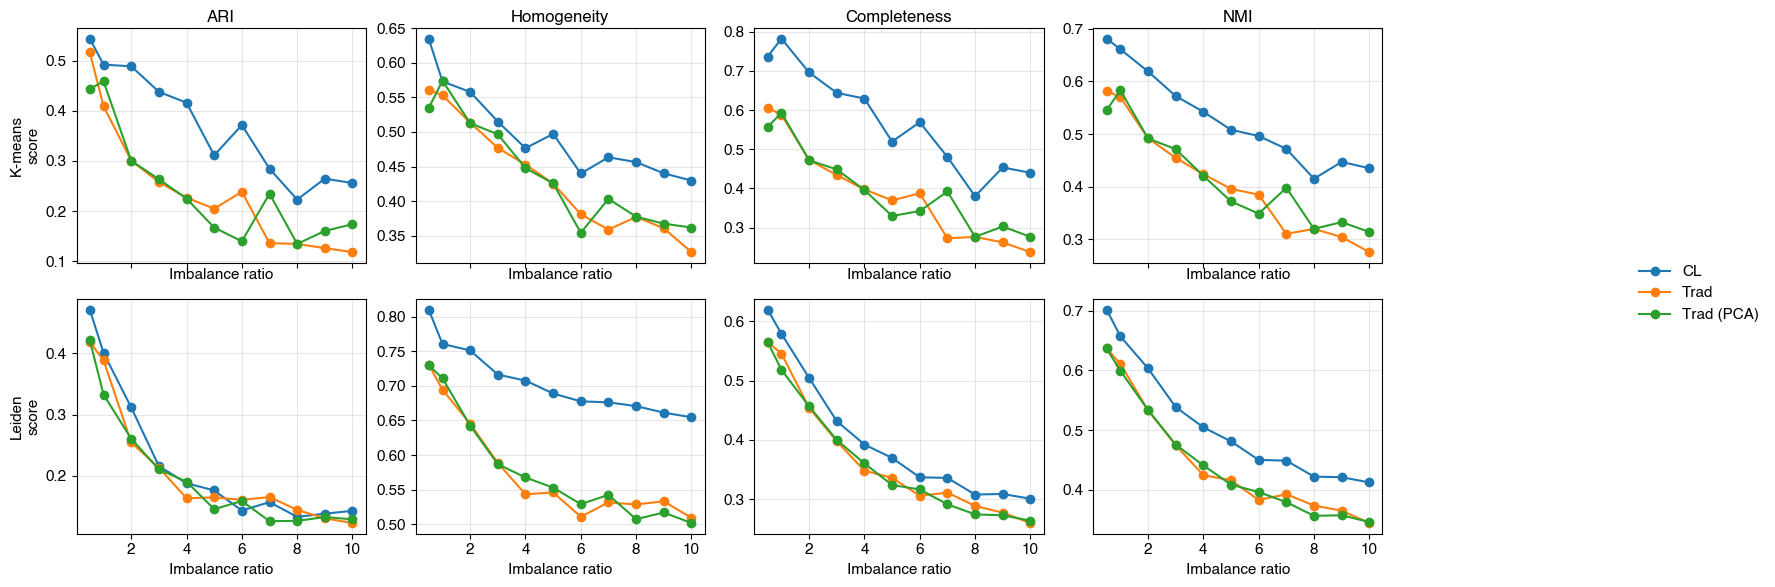

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- make absolutely sure every cell is a scalar number -------------------
long_df["ratio"]       = pd.to_numeric(long_df["ratio"]      , errors="coerce")
long_df["score_value"] = pd.to_numeric(long_df["score_value"], errors="coerce")

# optional but helpful: sort the curves left-to-right
long_df = long_df.sort_values("ratio")

# --- figure layout --------------------------------------------------------
score_names = long_df["score_name"].unique()
clusterings = long_df["clustering"].unique()
n_rows, n_cols = len(clusterings), len(score_names)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharex="col",  # same x-axis per column
    sharey=False
)

# axes is 2-D even for a single row/col; normalise to 2-D indexing
if n_rows == 1 and n_cols == 1:
    axes = np.array([[axes]])
elif n_rows == 1:
    axes = axes[np.newaxis, :]
elif n_cols == 1:
    axes = axes[:, np.newaxis]

# --- plot loop ------------------------------------------------------------
for i, clust in enumerate(clusterings):
    for j, score in enumerate(score_names):
        ax     = axes[i, j]
        subset = long_df.query("clustering == @clust and score_name == @score")

        for feat, d in subset.groupby("features"):
            ax.plot(
                d["ratio"],
                d["score_value"],
                marker="o",
                label=feat,
            )

        # cosmetics
        if i == 0:  # top row
            ax.set_title(score, fontsize=12, pad=4)
        if j == 0:  # leftmost column
            ax.set_ylabel(f"{clust}\nscore", fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel("Imbalance ratio")

# one shared legend, pushed outside the grid
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1])  # leave space for the legend
plt.show()


In [34]:
#save results2 
results_df2.to_csv('/mnt/deepstore/LBxPheno/figures/figurenew/results.csv', index=False)